imports

In [1]:
import pandas as pd
import seaborn as sns

writer = pd.ExcelWriter('./results/data_of_all.xlsx', engine='xlsxwriter')

config

In [2]:
config_prefix = ['TR', 'BR', 'TI', 'BI']

config_datasheet = r'./results/preprocessed.xlsx'

import df

In [3]:
raw = pd.read_excel(config_datasheet)
df = pd.DataFrame(raw)
df["Flag"] = df["Flag"].apply(str)

remove outliers

In [4]:
#split dataframes into dataframes for the 2*2 related factors
df_BU_R = df.loc[(df["ProgrammingStyle"]=="R") & (df["Comprehension"]=="BU")].drop("ClickData", axis=1)
df_BU_I = df.loc[(df["ProgrammingStyle"]=="I") & (df["Comprehension"]=="BU")].drop("ClickData", axis=1)
df_TD_R = df.loc[(df["ProgrammingStyle"]=="R") & (df["Comprehension"]=="TD")].drop("ClickData", axis=1)
df_TD_I = df.loc[(df["ProgrammingStyle"]=="I") & (df["Comprehension"]=="TD")].drop("ClickData", axis=1)

In [5]:
df_array_independent = [df_BU_R, df_BU_I, df_TD_R, df_TD_I]
df_means = [float(df["ResponseTime"].mean()) for df in df_array_independent]
df_stds = [float(df["ResponseTime"].std()) for df in df_array_independent]

for idx, df in enumerate(df_array_independent):
    mean = float(df_means[idx])
    stddev = float(df_stds[idx])
    for row_idx, row in df.iterrows():
        response_time = row["ResponseTime"]
        if mean+1.5*stddev < response_time < mean+2*stddev:
            df.loc[row_idx, "Flag"] = "notNormal"
            
        if response_time <= 30 and row["Correctness"] == False or response_time >= mean+2*stddev:
            df.loc[row_idx, "Flag"] = "Outlier"

df = df_BU_R
df = df.append(df_BU_I)
df = df.append(df_TD_R)
df = df.append(df_TD_I)
df.to_excel(writer, "labeled")

print(len(df))

for idx, df in enumerate(df_array_independent):
    df.loc[df["Flag"]=="Outlier", "ResponseTime"] = df_means[idx]
    
df_means

716


[10451.910994764397, 8935.115151515152, 11709.984126984127, 10899.309941520467]

In [6]:
for df_idx, _df in enumerate(df_array_independent):
    for row_idx, row in df.iterrows():
        id_value = row["Subject"]
        entries_id_BU_R = df_BU_R.loc[(df_BU_R["Subject"] == id_value) & (df_BU_R["Flag"] == "Outlier")]
        entries_id_BU_I = df_BU_I.loc[(df_BU_I["Subject"] == id_value) & (df_BU_I["Flag"] == "Outlier")] 
        entries_id_TD_R = df_TD_R.loc[(df_TD_R["Subject"] == id_value) & (df_TD_R["Flag"] == "Outlier")]
        entries_id_TD_I = df_TD_I.loc[(df_TD_I["Subject"] == id_value) & (df_TD_I["Flag"] == "Outlier")]
        
        df_per_id = entries_id_BU_R
        df_per_id = df_per_id.append(entries_id_BU_I)
        df_per_id = df_per_id.append(entries_id_TD_R)
        df_per_id = df_per_id.append(entries_id_TD_I)
        
        number_of_outliers_per_subject = len(df_per_id)
        
        if number_of_outliers_per_subject == 2:
            
            df_nn_BU_R = df_BU_R.loc[(df_BU_R["Subject"] == id_value) & (df_BU_R["Flag"] == "notNormal")]
            df_nn_BU_I = df_BU_I.loc[(df_BU_I["Subject"] == id_value) & (df_BU_I["Flag"] == "notNormal")]
            df_nn_TD_R = df_TD_R.loc[(df_TD_R["Subject"] == id_value) & (df_TD_R["Flag"] == "notNormal")]
            df_nn_TD_I = df_TD_I.loc[(df_TD_I["Subject"] == id_value) & (df_TD_I["Flag"] == "notNormal")]
            
            num_non_normals = len(df_nn_BU_R) + len(df_nn_BU_I) + len(df_nn_TD_R) + len(df_nn_TD_I)
            
            if num_non_normals > 0:
                print("Participant with the following number got deleted: " + str(id_value) + ". Because 2 where missing and " + str(num_non_normals) + " datapoints where not normal.")
                df_BU_R = df_BU_R.loc[df_BU_R["Subject"]!=id_value]
                df_BU_I = df_BU_I.loc[df_BU_I["Subject"]!=id_value]
                df_TD_R = df_TD_R.loc[df_TD_R["Subject"]!=id_value]
                df_TD_I = df_TD_I.loc[df_TD_I["Subject"]!=id_value]
                
        if number_of_outliers_per_subject > 2:
            print("Participant with the following number got deleted: " + str(id_value) + ". Because " + str(number_of_outliers_per_subject) + " where missing.")
            df_BU_R = df_BU_R.loc[df_BU_R["Subject"]!=id_value]
            df_BU_I = df_BU_I.loc[df_BU_I["Subject"]!=id_value]
            df_TD_R = df_TD_R.loc[df_TD_R["Subject"]!=id_value]
            df_TD_I = df_TD_I.loc[df_TD_I["Subject"]!=id_value]

df_array_independent = [df_BU_R, df_BU_I, df_TD_R, df_TD_I]
print(sum([len(df) for df in df_array_independent]))

716


In [7]:
#participants = []
#deleted = 0
algo_name_array = [name for name in df["Algorithm"].unique()]
#
#for idx, tmp_df in  enumerate(df_array_independent):
#    df_1 = df_BU_R
#    df_2 = df_BU_I
#    df_3 = df_TD_R
#    df_4 = df_TD_I
#    for idx, row in tmp_df.iterrows():
#        participant = row["Subject"]
#        
#        df_1_len = len(df_1.loc[df_1["Subject"]==participant])
#        df_2_len = len(df_2.loc[df_2["Subject"]==participant])
#        df_3_len = len(df_3.loc[df_3["Subject"]==participant])
#        df_4_len = len(df_4.loc[df_4["Subject"]==participant])
#        
#        if not(df_1_len == df_2_len == df_3_len == df_4_len):
#            participants.append(participant)
#            deleted += df_1_len + df_2_len + df_3_len + df_4_len
#            df_BU_R = df_BU_R.loc[df_BU_R["Subject"]!=participant]
#            df_BU_I = df_BU_I.loc[df_BU_I["Subject"]!=participant]
#            df_TD_R = df_TD_R.loc[df_TD_R["Subject"]!=participant]
#            df_TD_I = df_TD_I.loc[df_TD_I["Subject"]!=participant]
#            print(str(participant) + ": " + str(df_1_len) + " " + str(df_2_len) + " " + str(df_3_len) + " " + str(df_4_len))

In [8]:
total_df = df_BU_R
total_df = total_df.append(df_BU_I)
total_df = total_df.append(df_TD_R)
total_df = total_df.append(df_TD_I)
total_df.to_csv("data_of_all_removed.csv")

split dataframes 

In [9]:
df_cat_array = df_array_independent

df = df_array_independent[0]
df = df.append(df_array_independent[1])
df = df.append(df_array_independent[2])
df = df.append(df_array_independent[3])

df_algo_cat_array = []
for algo_name in algo_name_array:
    tmp_df = []
    tmp_df.append(df.loc[(df["Algorithm"]==algo_name) & (df["ProgrammingStyle"]=="R") & (df["Comprehension"]=="BU")])
    tmp_df.append(df.loc[(df["Algorithm"]==algo_name) & (df["ProgrammingStyle"]=="I") & (df["Comprehension"]=="BU")])
    tmp_df.append(df.loc[(df["Algorithm"]==algo_name) & (df["ProgrammingStyle"]=="R") & (df["Comprehension"]=="TD")])
    tmp_df.append(df.loc[(df["Algorithm"]==algo_name) & (df["ProgrammingStyle"]=="I") & (df["Comprehension"]=="TD")])
    df_algo_cat_array.append(tmp_df)

create result

In [10]:
cols = ["Algorithm", "Comprehension",
        "rec correct", "rec total Answers", "rec percent", "R_ResponseTimeMean", "R_ResponseTimeDeviation",
        "it correct", "it total Answers", "it percent", "I_ResponseTimeMean", "I_ResponseTimeDeviation"]

result_df = pd.DataFrame(columns=cols)

count_cols = ["Algorithm", "Comprehension", "Programming", "Right", "Total"]
count_df = pd.DataFrame(columns=count_cols)

for algo_df_array in df_algo_cat_array:
    for i in range(2):
        rec =  algo_df_array[i*2+0]
        it =  algo_df_array[i*2+1]
        
        Algorithm = rec.iloc[0]["Algorithm"]
        Comprehension = "Bottom-Up"
        if i == 1:
            Comprehension = "Top-Down"
            
        count_df = count_df.append(pd.DataFrame([[Algorithm, Comprehension, "R", len(rec.loc[rec["Correctness"]==True]) ,len(rec)]], columns=count_cols))
        count_df = count_df.append(pd.DataFrame([[Algorithm, Comprehension, "I", len(it.loc[it["Correctness"]==True]) ,len(it)]], columns=count_cols))
        
        R_ResponseTimeMean = int(rec["ResponseTime"].mean())
        R_ResponseTimeDeviation = int(rec["ResponseTime"].std())
        
        I_ResponseTimeMean = int(it["ResponseTime"].mean())
        I_ResponseTimeDeviation = int(it["ResponseTime"].std())
        
        rec_cor = len(rec.loc[rec["Correctness"]==True])
        rec_total = len(rec)
        rec_percent = rec_cor/rec_total
        
        it_cor = len(it.loc[it["Correctness"]==True])
        it_total = len(it)
        it_percent = it_cor/it_total
        
        data = [
            Algorithm, Comprehension,
            rec_cor, rec_total, rec_percent, R_ResponseTimeMean, R_ResponseTimeDeviation,
            it_cor, it_total, it_percent, I_ResponseTimeMean, I_ResponseTimeDeviation,
        ]
        
        result_df = result_df.append(pd.DataFrame([data], columns=cols))
        



for i in range(2):
    rec =  df_cat_array[i*2+0]
    it =  df_cat_array[i*2+1]
    
    Algorithm = "Total"
    Comprehension = "Top-Down"
    if i == 1:
        Comprehension = "Bottom-Up"
    
    R_ResponseTimeMean = int(rec["ResponseTime"].mean())
    R_ResponseTimeDeviation = int(rec["ResponseTime"].std())
    
    I_ResponseTimeMean = int(it["ResponseTime"].mean())
    I_ResponseTimeDeviation = int(it["ResponseTime"].std())
    
    rec_cor = len(rec.loc[rec["Correctness"]==True])
    rec_total = len(rec)
    rec_percent = rec_cor/rec_total
    
    it_cor = len(it.loc[it["Correctness"]==True])
    it_total = len(it)
    it_percent = it_cor/it_total
    
    data = [
        Algorithm, Comprehension,
        rec_cor, rec_total, rec_percent, R_ResponseTimeMean, R_ResponseTimeDeviation,
        it_cor, it_total, it_percent, I_ResponseTimeMean, I_ResponseTimeDeviation,
    ]
    
    result_df = result_df.append(pd.DataFrame([data], columns=cols))
    
df_recursive = df_array_independent[0]     
df_recursive = df_recursive.append(df_array_independent[2])

df_iterative = df_array_independent[1]     
df_iterative = df_iterative.append(df_array_independent[3])

rec_cor = len(df_recursive.loc[df_recursive["Correctness"]==True])
rec_total = len(df_recursive)
rec_percent = rec_cor/rec_total

it_cor = len(df_iterative.loc[df_iterative["Correctness"]==True])
it_total = len(df_iterative)
it_percent = it_cor/it_total

result_df = result_df.append(pd.DataFrame(
    [["Total", "Total",
    rec_cor, rec_total, rec_percent, int(df_recursive["ResponseTime"].mean()), int(df_recursive["ResponseTime"].std()),
    it_cor, it_total, it_percent, int(df_iterative["ResponseTime"].mean()), int(df_iterative["ResponseTime"].std())]],
    columns=cols))

print("Write total means to excel sheet")
result_df.to_excel(writer, sheet_name="corrects.info")
writer.save()
result_df

Write total means to excel sheet


,Algorithm,Comprehension,rec correct,rec total Answers,rec percent,R_ResponseTimeMean,R_ResponseTimeDeviation,it correct,it total Answers,it percent,I_ResponseTimeMean,I_ResponseTimeDeviation
0,BinarySearch,Bottom-Up,16,23,0.695652,10057,6258,19,23,0.826087,10165,8391
0,BinarySearch,Top-Down,26,27,0.962963,12972,9364,15,19,0.789474,10022,7484
0,BubbleSort,Bottom-Up,22,22,1.000000,10715,6708,21,25,0.840000,9148,6311
0,BubbleSort,Top-Down,23,24,0.958333,11778,5897,11,14,0.785714,7287,4440
0,Factorial,Bottom-Up,21,21,1.000000,7972,2262,22,22,1.000000,7072,2857
0,Factorial,Top-Down,23,25,0.920000,10207,4879,22,24,0.916667,10978,5108
0,Fibonacci,Bottom-Up,18,23,0.782609,7953,2225,18,18,1.000000,4849,1559
0,Fibonacci,Top-Down,17,20,0.850000,6850,6111,20,23,0.869565,13249,6299
0,IntegerBinary,Bottom-Up,23,24,0.958333,4828,1664,13,18,0.722222,4298,1643
0,IntegerBinary,Top-Down,25,25,1.000000,9499,6145,18,21,0.857143,11300,5524


In [11]:
combine_lambda = lambda x: '{}_{}'.format(x["Comprehension"], x["ProgrammingStyle"])
total_df.insert(loc=6, column="ProgrammingStyle x Comprehension", value=total_df.apply(combine_lambda, axis = 1))
total_df = total_df.loc[total_df["ResponseTime"] < 17000]

In [12]:
import matplotlib.pyplot as plt

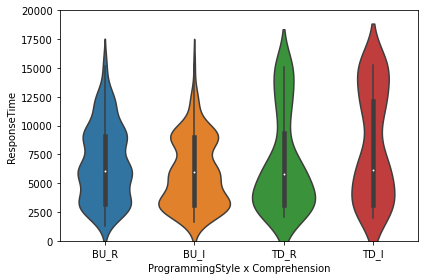

In [20]:
plt.ylim(0, 20000)
ax = sns.violinplot(x="ProgrammingStyle x Comprehension", y="ResponseTime", data=total_df)
plt.tight_layout()
plt.savefig("results/behavioral/violin_of_all.pdf", bbox_inches='tight', pad_inches=0.01)

FileNotFoundError: [Errno 2] No such file or directory: 'results/behavioral/box_of_all.pdf'

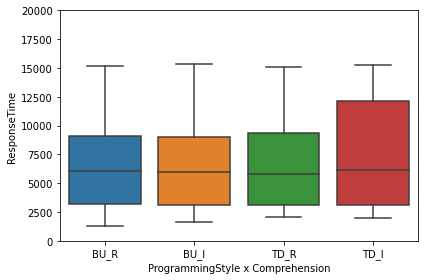

In [15]:
plt.ylim(0, 20000)
ax = sns.boxplot(x="ProgrammingStyle x Comprehension", y="ResponseTime", data=total_df)
plt.tight_layout()
plt.savefig("results/behavioral/box_of_all.pdf", bbox_inches='tight', pad_inches=0.01)

FileNotFoundError: [Errno 2] No such file or directory: 'results/behavioral/bar_correctness_of_all.pdf'

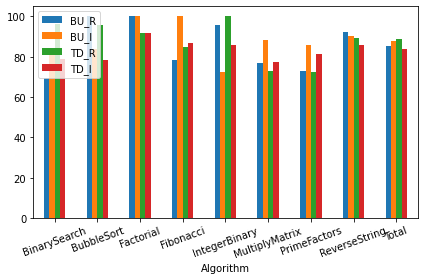

In [17]:
result_df
cols = ["Algorithm", "BU_R", "BU_I", "TD_R", "TD_I"]
bar_df = pd.DataFrame([], columns=cols)

for i in range(int(len(result_df[:-1])/2)):
    idx = 2*i
    algorithm = result_df.iloc[idx]["Algorithm"]
    BU_I = result_df.iloc[idx]["it percent"]*100
    BU_R = result_df.iloc[idx]["rec percent"]*100
    TD_I = result_df.iloc[idx + 1]["it percent"]*100
    TD_R = result_df.iloc[idx + 1]["rec percent"]*100
    
    bar_df = bar_df.append(pd.DataFrame([[algorithm, BU_R, BU_I, TD_R, TD_I]], columns=cols))

bar_df = bar_df.set_index('Algorithm')
ax = bar_df.plot.bar(rot=380)
plt.tight_layout()
ax.legend(loc="upper left")
plt.savefig("results/behavioral/bar_correctness_of_all.pdf", bbox_inches='tight', pad_inches=0.01)

FileNotFoundError: [Errno 2] No such file or directory: 'results/behavioral/bar_response_of_all.pdf'

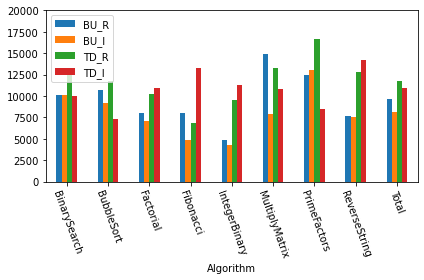

In [18]:
result_df
cols = ["Algorithm", "BU_R", "BU_I", "TD_R", "TD_I"]
bar_df = pd.DataFrame([], columns=cols)

for i in range(int(len(result_df[:-1])/2)):
    idx = 2*i
    algorithm = result_df.iloc[idx]["Algorithm"]
    BU_I = result_df.iloc[idx]["I_ResponseTimeMean"]
    BU_R = result_df.iloc[idx]["R_ResponseTimeMean"]
    TD_I = result_df.iloc[idx + 1]["I_ResponseTimeMean"]
    TD_R = result_df.iloc[idx + 1]["R_ResponseTimeMean"]
    
    bar_df = bar_df.append(pd.DataFrame([[algorithm, BU_R, BU_I, TD_R, TD_I]], columns=cols))

bar_df = bar_df.set_index('Algorithm')
ax = bar_df.plot.bar(rot=290)
plt.ylim(0, 20000)
plt.tight_layout()
ax.legend(loc="upper left")
plt.savefig("results/behavioral/bar_response_of_all.pdf", bbox_inches='tight', pad_inches=0.01)

In [5]:
from scipy.stats import chisquare
chisquare([163, 168, 145, 143],[191, 189, 165, 171])
#chisquare([331,288],[380, 336])

# If the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist.

Power_divergenceResult(statistic=13.447083121098, pvalue=0.003763073705120512)